# Classification of Trip Advisor Reviews

# 1 Data & Input Processing

In this section, the data is pulled into the environment and basic analysis is performed on it.

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import timeit

import nltk as nlp #Natural language toolkit
nlp.download("stopwords")  #downloading stopwords
nlp.download('punkt')
from nltk import word_tokenize,sent_tokenize
nlp.download('wordnet')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv
/kaggle/input/lgbm-gridsearch/LGBM_GridSearch.sav


# 1.1 Read the data and show a sample.

In [2]:
dataset = pd.read_csv('/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
dataset.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


# 1.2 Show data statistics

In [13]:
# Show data statistics and accuracy when all predictions are set to 5.
numReviews = len(dataset)
realRatings = dataset['Rating']

print(realRatings.describe())

print(numReviews)
def accuracy(predictions, real):
    amount_correct = list(map(lambda x: x[0] == x[1], zip(predictions, real))).count(True)
    return amount_correct / len(predictions)
basePrediction = np.array(list([5 for i in range(numReviews)]))
print()
print("The accuracy with rating every review as 5 is " + str(accuracy(basePrediction, list(dataset['Rating']))))

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64
20491

The accuracy with rating every review as 5 is 0.44185252061880825


In [12]:
#Checking the dataset for null values.
dataset.isnull().sum()

Review    0
Rating    0
dtype: int64

As seen above, there are no null values in the data.

# 1.3 Display a bar chart with distribution of ratings

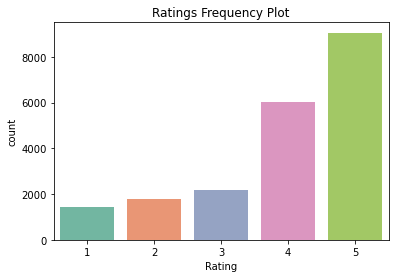

In [14]:
distPlot = sns.countplot(data=dataset,x='Rating',palette="Set2").set_title('Ratings Frequency Plot')
distPlot.figure.savefig("distPlot.png")

# 1.4 Display a word cloud with most common words in Review column

In [16]:
#Ref: https://www.kaggle.com/shahraizanwar/hotel-reviews-sentiment-prediction
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title,fontsize=30)
    plt.savefig('wordCloud.png')
    plt.show()

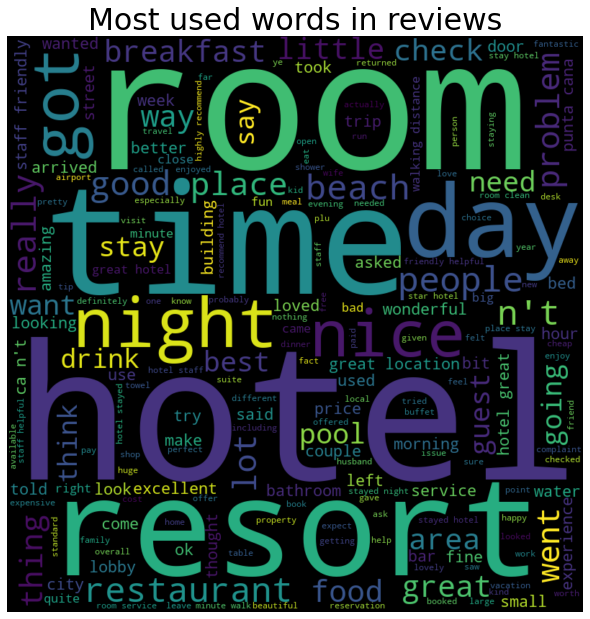

In [17]:
wordCloud_generator(dataset['Review'], title="Most used words in reviews")

# 1.5 Text Encoding with universal-sentence-encoder and training/testing set creation

In [3]:
%%time
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,log_loss,precision_score, make_scorer
from lightgbm import LGBMClassifier

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
train, test = train_test_split(dataset, test_size = 0.1, random_state = 42)
X_train = embed(train.Review.to_numpy()).numpy()
X_test = embed(test.Review.to_numpy()).numpy()
y_train = train.Rating.to_numpy()
y_test = test.Rating.to_numpy()

CPU times: user 1min 6s, sys: 22.9 s, total: 1min 29s
Wall time: 1min 15s


# 2 Classification Model Training & Hyperparameter Optimization

# 2.1 LGBMClassifier()

In [24]:
# Training base model for LGBMClassifier()
startTime = timeit.default_timer()
lgbmModel = LGBMClassifier(random_state = 42)
lgbmModel.fit(X_train, y_train)
y_pred=lgbmModel.predict(X_test)

acc_base_LGBM = accuracy_score(y_test, y_pred)
time_base_LGBM = timeit.default_timer() - startTime

print("Accuracy for base LGBMCLassifier: ", acc_base_LGBM)
print("Time Taken: ", time_base_LGBM)

Accuracy for base LGBMCLassifier:  0.5965853658536585
Time Taken:  48.211945187998936


In [25]:
# Make the accuracy_scorer for GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle

acc_scorer = make_scorer(accuracy_score)

In [ ]:
# Hyperparameter tuning for LGBMClassifier. NOTE: Running this block will take ~3 hrs
param_grid =[
    {'num_leaves': [30, 40, 50, 60, 70], 'min_child_samples': [20, 40, 80, 120], 'max_depth': [-1, 3, 5, 7]}
]
clfLGBM = GridSearchCV(lgbmModel, param_grid, scoring = acc_scorer, cv = 5, verbose = 2)
clfLGBM.fit(X_train, y_train)

In [ ]:
# Writing output of hyperparameter tuning to file
filename = "LGBM_GridSearch.sav"
pickle.dump(clfLGBM, open(filename, 'wb'))

In [26]:
# Load GridSearchCV object from file
clfLGBM = pickle.load(open("/kaggle/input/lgbm-gridsearch/LGBM_GridSearch.sav","rb"))

In [35]:
# Best Estimator for LGBMClassifier
clfLGBM.best_estimator_

LGBMClassifier(min_child_samples=120, num_leaves=50, random_state=42)

In [27]:
# Training best model for LGBMClassifier()
startTime = timeit.default_timer()
bestLGBMModel = clfLGBM.best_estimator_
bestLGBMModel.fit(X_train, y_train)
y_pred_LGBM_best_model = bestLGBMModel.predict(X_test)

acc_best_LGBM = accuracy_score(y_test, y_pred_LGBM_best_model)
time_best_LGBM = timeit.default_timer() - startTime

print("Accuracy for best LGBMClassifier: ", acc_best_LGBM)
print("Time Taken: ", time_best_LGBM)

Accuracy for best LGBMClassifier:  0.5975609756097561
Time Taken:  54.27300601800016


# 2.2 AdaBoostClassifier()

In [28]:
# Training base model for AdaBoostClassifier()
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

startTime = timeit.default_timer()

adaBoostModel = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state = 42)
adaBoostModel.fit(X_train, y_train)

y_pred_ada_boost = adaBoostModel.predict(X_test)

acc_base_ada = accuracy_score(y_test, y_pred_ada_boost)
time_base_ada = timeit.default_timer() - startTime

print("Accuracyfor base AdaBoostClassifier:", acc_base_ada)
print("Time Taken: ", time_base_ada)

Accuracyfor base AdaBoostClassifier: 0.5395121951219513
Time Taken:  79.52136144299948


In [ ]:
# Hyperparameter tuning for AdaBoostClassifier. NOTE: Running this block will take ~4 hrs
ada_param_grid = [{
 'n_estimators': [20, 50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'algorithm' : ['SAMME', 'SAMME.R']
 }]
acc_scorer = make_scorer(accuracy_score)
clfAdaBoost = GridSearchCV(adaBoostModel, ada_param_grid, scoring = acc_scorer, cv = 5, verbose = 2)
clfAdaBoost.fit(X_train, y_train)

In [29]:
# Training best model for AdaBoostClassifier()
## The parameters here are put explicitly instead of taking from GridSearchCV object as I forgot to save it.
## Complete GridSearchCV takes around ~4 hours for AdaBoost so I decided against running it again.
startTime = timeit.default_timer()
adaBoostBestModel = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = 100, learning_rate = 0.3, 
                                       algorithm = 'SAMME.R', random_state = 42)
adaBoostBestModel.fit(X_train, y_train)

y_pred_ada_best_model = adaBoostBestModel.predict(X_test)

acc_best_ada = accuracy_score(y_test, y_pred_ada_best_model)
time_best_ada = timeit.default_timer() - startTime

print("Accuracy for best AdaBoostClassifier: ", )
print("Time Taken: ", time_best_ada)

Accuracy for best AdaBoostClassifier:  0.551219512195122
Time Taken:  155.44136189799974


# 2.3 LogisticRegression()

In [30]:
# Training base model for LogisticRegression()
from sklearn.linear_model import LogisticRegression

startTime = timeit.default_timer()
logRegModel = LogisticRegression(random_state = 42)
logRegModel.fit(X_train, y_train)

y_pred_log_reg = logRegModel.predict(X_test)

acc_base_logreg = accuracy_score(y_test, y_pred_log_reg)
time_base_logreg = timeit.default_timer() - startTime

print("Accuracy for base LogisticRegression: ", acc_base_logreg)
print("Time Taken: ", time_base_logreg)

Accuracy for base LogisticRegression:  0.6141463414634146
Time Taken:  3.4104041119990143


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [8]:
# Hyperparameter tuning for LogisticRegression. NOTE: Running this block will take ~2 hrs
log_param_grid =[
    {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'penalty' : ['none']},
    {'C': [100, 10, 1.0, 0.1, 0.01], 'solver': ['saga'],
    'penalty' : ['l1', 'l2', 'elasticnet']},
    {'C': [100, 10, 1.0, 0.1, 0.01], 'solver': ['newton-cg', 'lbfgs', 'sag'],
    'penalty' : ['l2']},
    {'C': [100, 10, 1.0, 0.1, 0.01], 'solver': ['liblinear'],
    'penalty' : ['l1', 'l2']}]
acc_scorer = make_scorer(accuracy_score)
clfLogReg = GridSearchCV(logRegModel, log_param_grid, scoring = acc_scorer, cv = 5, verbose = 2)
clfLogReg.fit(X_train, y_train)

Fitting 5 folds for each of 44 candidates, totalling 220 fits
[CV] penalty=none, solver=newton-cg ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] ................... penalty=none, solver=newton-cg, total= 1.7min
[CV] penalty=none, solver=newton-cg ..................................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ................... penalty=none, solver=newton-cg, total= 1.6min
[CV] penalty=none, solver=newton-cg ..................................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ................... penalty=none, solver=newton-cg, total= 1.9min
[CV] penalty=none, solver=newton-cg ..................................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ................... penalty=none, solver=newton-cg, total= 1.6min
[CV] penalty=none, solver=newton-cg ..................................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ................... penalty=none, solver=newton-cg, total= 1.2min
[CV] penalty=none, solver=lbfgs ......................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ....................... penalty=none, solver=lbfgs, total=   2.6s
[CV] penalty=none, solver=lbfgs ......................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ....................... penalty=none, solver=lbfgs, total=   2.4s
[CV] penalty=none, solver=lbfgs ......................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ....................... penalty=none, solver=lbfgs, total=   2.4s
[CV] penalty=none, solver=lbfgs ......................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ....................... penalty=none, solver=lbfgs, total=   2.4s
[CV] penalty=none, solver=lbfgs ......................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ....................... penalty=none, solver=lbfgs, total=   2.5s
[CV] penalty=none, solver=sag ........................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ......................... penalty=none, solver=sag, total=  21.6s
[CV] penalty=none, solver=sag ........................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ......................... penalty=none, solver=sag, total=  21.6s
[CV] penalty=none, solver=sag ........................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ......................... penalty=none, solver=sag, total=  21.7s
[CV] penalty=none, solver=sag ........................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ......................... penalty=none, solver=sag, total=  21.6s
[CV] penalty=none, solver=sag ........................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ......................... penalty=none, solver=sag, total=  21.9s
[CV] penalty=none, solver=saga .......................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........................ penalty=none, solver=saga, total=  32.8s
[CV] penalty=none, solver=saga .......................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........................ penalty=none, solver=saga, total=  32.9s
[CV] penalty=none, solver=saga .......................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........................ penalty=none, solver=saga, total=  33.0s
[CV] penalty=none, solver=saga .......................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........................ penalty=none, solver=saga, total=  32.9s
[CV] penalty=none, solver=saga .......................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........................ penalty=none, solver=saga, total=  32.9s
[CV] C=100, penalty=l1, solver=saga ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l1, solver=saga, total=  46.0s
[CV] C=100, penalty=l1, solver=saga ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l1, solver=saga, total=  46.3s
[CV] C=100, penalty=l1, solver=saga ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l1, solver=saga, total=  46.3s
[CV] C=100, penalty=l1, solver=saga ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l1, solver=saga, total=  46.1s
[CV] C=100, penalty=l1, solver=saga ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l1, solver=saga, total=  46.0s
[CV] C=100, penalty=l2, solver=saga ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l2, solver=saga, total=  33.2s
[CV] C=100, penalty=l2, solver=saga ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l2, solver=saga, total=  32.9s
[CV] C=100, penalty=l2, solver=saga ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l2, solver=saga, total=  33.1s
[CV] C=100, penalty=l2, solver=saga ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l2, solver=saga, total=  33.2s
[CV] C=100, penalty=l2, solver=saga ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)


[CV] ................... C=100, penalty=l2, solver=saga, total=  33.1s
[CV] C=100, penalty=elasticnet, solver=saga ..........................
[CV] ........... C=100, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=saga ..........................
[CV] ........... C=100, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=saga ..........................
[CV] ........... C=100, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=saga ..........................
[CV] ........... C=100, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=saga ..........................
[CV] ........... C=100, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=10, penalty=l1, solver=saga ...................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=10, penalty=l1, solver=saga, total=  46.4s
[CV] C=10, penalty=l1, solver=saga ...................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=10, penalty=l1, solver=saga, total=  45.9s
[CV] C=10, penalty=l1, solver=saga ...................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=10, penalty=l1, solver=saga, total=  45.6s
[CV] C=10, penalty=l1, solver=saga ...................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=10, penalty=l1, solver=saga, total=  46.1s
[CV] C=10, penalty=l1, solver=saga ...................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=10, penalty=l1, solver=saga, total=  45.9s
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total=  18.0s
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total=  19.3s
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total=  17.5s
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total=  17.2s
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total=  17.1s
[CV] C=10, penalty=elasticnet, solver=saga ...........................
[CV] ............ C=10, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=10, penalty=elasticnet, solver=saga ...........................
[CV] .

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)


[CV] ................... C=1.0, penalty=l1, solver=saga, total=  35.9s
[CV] C=1.0, penalty=l1, solver=saga ..................................
[CV] ................... C=1.0, penalty=l1, solver=saga, total=  33.7s
[CV] C=1.0, penalty=l1, solver=saga ..................................
[CV] ................... C=1.0, penalty=l1, solver=saga, total=  33.3s
[CV] C=1.0, penalty=l1, solver=saga ..................................
[CV] ................... C=1.0, penalty=l1, solver=saga, total=  34.0s
[CV] C=1.0, penalty=l1, solver=saga ..................................
[CV] ................... C=1.0, penalty=l1, solver=saga, total=  35.2s
[CV] C=1.0, penalty=l2, solver=saga ..................................
[CV] ................... C=1.0, penalty=l2, solver=saga, total=   7.9s
[CV] C=1.0, penalty=l2, solver=saga ..................................
[CV] ................... C=1.0, penalty=l2, solver=saga, total=   8.4s
[CV] C=1.0, penalty=l2, solver=saga ..................................
[CV] .

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)


[CV] ................... C=0.1, penalty=l1, solver=saga, total=  14.7s
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] ................... C=0.1, penalty=l1, solver=saga, total=  13.1s
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] ................... C=0.1, penalty=l1, solver=saga, total=  12.8s
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] ................... C=0.1, penalty=l1, solver=saga, total=  14.0s
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] ................... C=0.1, penalty=l1, solver=saga, total=  12.7s
[CV] C=0.1, penalty=l2, solver=saga ..................................
[CV] ................... C=0.1, penalty=l2, solver=saga, total=   7.6s
[CV] C=0.1, penalty=l2, solver=saga ..................................
[CV] ................... C=0.1, penalty=l2, solver=saga, total=   7.7s
[CV] C=0.1, penalty=l2, solver=saga ..................................
[CV] .

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)


[CV] .................. C=0.01, penalty=l1, solver=saga, total=   8.0s
[CV] C=0.01, penalty=l1, solver=saga .................................
[CV] .................. C=0.01, penalty=l1, solver=saga, total=   6.1s
[CV] C=0.01, penalty=l1, solver=saga .................................
[CV] .................. C=0.01, penalty=l1, solver=saga, total=   7.6s
[CV] C=0.01, penalty=l1, solver=saga .................................
[CV] .................. C=0.01, penalty=l1, solver=saga, total=   7.3s
[CV] C=0.01, penalty=l1, solver=saga .................................
[CV] .................. C=0.01, penalty=l1, solver=saga, total=   6.5s
[CV] C=0.01, penalty=l2, solver=saga .................................
[CV] .................. C=0.01, penalty=l2, solver=saga, total=   7.7s
[CV] C=0.01, penalty=l2, solver=saga .................................
[CV] .................. C=0.01, penalty=l2, solver=saga, total=   7.8s
[CV] C=0.01, penalty=l2, solver=saga .................................
[CV] .

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=100, penalty=l2, solver=newton-cg, total= 1.3min
[CV] C=100, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=100, penalty=l2, solver=newton-cg, total=  55.7s
[CV] C=100, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=100, penalty=l2, solver=newton-cg, total=  54.2s
[CV] C=100, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=100, penalty=l2, solver=newton-cg, total= 1.0min
[CV] C=100, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=100, penalty=l2, solver=newton-cg, total= 2.0min
[CV] C=100, penalty=l2, solver=lbfgs .................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=100, penalty=l2, solver=lbfgs, total=   2.4s
[CV] C=100, penalty=l2, solver=lbfgs .................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=100, penalty=l2, solver=lbfgs, total=   2.3s
[CV] C=100, penalty=l2, solver=lbfgs .................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=100, penalty=l2, solver=lbfgs, total=   2.4s
[CV] C=100, penalty=l2, solver=lbfgs .................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=100, penalty=l2, solver=lbfgs, total=   2.5s
[CV] C=100, penalty=l2, solver=lbfgs .................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=100, penalty=l2, solver=lbfgs, total=   2.3s
[CV] C=100, penalty=l2, solver=sag ...................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=100, penalty=l2, solver=sag, total=  21.6s
[CV] C=100, penalty=l2, solver=sag ...................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=100, penalty=l2, solver=sag, total=  21.6s
[CV] C=100, penalty=l2, solver=sag ...................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=100, penalty=l2, solver=sag, total=  21.7s
[CV] C=100, penalty=l2, solver=sag ...................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=100, penalty=l2, solver=sag, total=  21.6s
[CV] C=100, penalty=l2, solver=sag ...................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=100, penalty=l2, solver=sag, total=  21.6s
[CV] C=10, penalty=l2, solver=newton-cg ..............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ............... C=10, penalty=l2, solver=newton-cg, total=  21.1s
[CV] C=10, penalty=l2, solver=newton-cg ..............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ............... C=10, penalty=l2, solver=newton-cg, total=  31.4s
[CV] C=10, penalty=l2, solver=newton-cg ..............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ............... C=10, penalty=l2, solver=newton-cg, total=  26.6s
[CV] C=10, penalty=l2, solver=newton-cg ..............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ............... C=10, penalty=l2, solver=newton-cg, total=  27.5s
[CV] C=10, penalty=l2, solver=newton-cg ..............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ............... C=10, penalty=l2, solver=newton-cg, total=  21.8s
[CV] C=10, penalty=l2, solver=lbfgs ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................... C=10, penalty=l2, solver=lbfgs, total=   2.5s
[CV] C=10, penalty=l2, solver=lbfgs ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................... C=10, penalty=l2, solver=lbfgs, total=   2.4s
[CV] C=10, penalty=l2, solver=lbfgs ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................... C=10, penalty=l2, solver=lbfgs, total=   2.4s
[CV] C=10, penalty=l2, solver=lbfgs ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................... C=10, penalty=l2, solver=lbfgs, total=   2.4s
[CV] C=10, penalty=l2, solver=lbfgs ..................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................... C=10, penalty=l2, solver=lbfgs, total=   2.4s
[CV] C=10, penalty=l2, solver=sag ....................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... C=10, penalty=l2, solver=sag, total=  21.8s
[CV] C=10, penalty=l2, solver=sag ....................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... C=10, penalty=l2, solver=sag, total=  21.7s
[CV] C=10, penalty=l2, solver=sag ....................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... C=10, penalty=l2, solver=sag, total=  21.7s
[CV] C=10, penalty=l2, solver=sag ....................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... C=10, penalty=l2, solver=sag, total=  21.7s
[CV] C=10, penalty=l2, solver=sag ....................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... C=10, penalty=l2, solver=sag, total=  21.6s
[CV] C=1.0, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=1.0, penalty=l2, solver=newton-cg, total=  15.2s
[CV] C=1.0, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=1.0, penalty=l2, solver=newton-cg, total=  14.4s
[CV] C=1.0, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=1.0, penalty=l2, solver=newton-cg, total=  15.5s
[CV] C=1.0, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=1.0, penalty=l2, solver=newton-cg, total=  10.4s
[CV] C=1.0, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=1.0, penalty=l2, solver=newton-cg, total=  10.7s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   2.4s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   2.4s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   2.5s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   2.5s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   2.6s
[CV] C=1.0, penalty=l2, solver=sag ...................................
[CV] .................... C=1.0, penalty=l2, solver=sag, total=   7.3s
[CV] C=1.0, penalty=l2, solver=sag ...................................
[CV] .................... C=1.0, penalty=l2, solver=sag, total=   7.6s
[CV] C=1.0, penalty=l2, solver=sag ...................................
[CV] .................... C=1.0, penalty=l2, solver=sag, total=   7.4s
[CV] C=1.0, penalty=l2, solver=sag ...................................
[CV] .................... C=1.0, penalty=l2, solver=sag, total=   9.1s
[CV] C=1.0, penalty=l2, solver=sag ...................................
[CV] .................... C=1.0, penalty=l2, solver=sag, total=   7.8s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=0.1, penalty=l2, solver=newton-cg, total=   8.1s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=0.1, penalty=l2, solver=newton-cg, total=   5.7s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=0.1, penalty=l2, solver=newton-cg, total=   7.1s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=0.1, penalty=l2, solver=newton-cg, total=   8.5s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .............. C=0.1, penalty=l2, solver=newton-cg, total=   7.8s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] .................. C=0.1, penalty=l2, solver=lbfgs, total=   1.8s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] .................. C=0.1, penalty=l2, solver=lbfgs, total=   1.6s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] .................. C=0.1, penalty=l2, solver=lbfgs, total=   1.8s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] .................. C=0.1, penalty=l2, solver=lbfgs, total=   1.6s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] .................. C=0.1, penalty=l2, solver=lbfgs, total=   1.7s
[CV] C=0.1, penalty=l2, solver=sag ...................................
[CV] .................... C=0.1, penalty=l2, solver=sag, total=   3.7s
[CV] C=0.1, penalty=l2, solver=sag ...................................
[CV] .

/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ............. C=0.01, penalty=l2, solver=newton-cg, total=   6.4s
[CV] C=0.01, penalty=l2, solver=newton-cg ............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ............. C=0.01, penalty=l2, solver=newton-cg, total=   3.7s
[CV] C=0.01, penalty=l2, solver=newton-cg ............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ............. C=0.01, penalty=l2, solver=newton-cg, total=   5.4s
[CV] C=0.01, penalty=l2, solver=newton-cg ............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ............. C=0.01, penalty=l2, solver=newton-cg, total=   4.7s
[CV] C=0.01, penalty=l2, solver=newton-cg ............................


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ............. C=0.01, penalty=l2, solver=newton-cg, total=   6.0s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] ................. C=0.01, penalty=l2, solver=lbfgs, total=   0.8s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] ................. C=0.01, penalty=l2, solver=lbfgs, total=   0.8s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] ................. C=0.01, penalty=l2, solver=lbfgs, total=   0.7s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] ................. C=0.01, penalty=l2, solver=lbfgs, total=   0.7s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] ................. C=0.01, penalty=l2, solver=lbfgs, total=   0.7s
[CV] C=0.01, penalty=l2, solver=sag ..................................
[CV] ................... C=0.01, penalty=l2, solver=sag, total=   3.3s
[CV] C=0.01, penalty=l2, solver=sag ..................................
[CV] .

[CV] ............. C=0.01, penalty=l2, solver=liblinear, total=   4.7s
[CV] C=0.01, penalty=l2, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l2, solver=liblinear, total=   4.7s
[CV] C=0.01, penalty=l2, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l2, solver=liblinear, total=   4.5s


[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed: 139.4min finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid=[{'penalty': ['none'],
                          'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
                         {'C': [100, 10, 1.0, 0.1, 0.01],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['saga']},
                         {'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'sag']},
                         {'C': [100, 10, 1.0, 0.1, 0.01],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}],
             scoring=make_scorer(accuracy_score), verbose=2)

In [9]:
# Writing output of hyperparameter tuning to file
filename = "LR_GridSearch.sav"
pickle.dump(clfLogReg, open(filename, 'wb'))

In [32]:
# Load GridSearchCV object from file
clfLogReg = pickle.load(open("/kaggle/input/lrgridsearch/LR_GridSearch.sav","rb"))

In [34]:
# Best Estimator for LogisticRegression
clfLogReg.best_estimator_

LogisticRegression(C=10, random_state=42)

In [33]:
# Training best model for LogisticRegression()
startTime = timeit.default_timer()
logRegBestModel = clfLogReg.best_estimator_
logRegBestModel.fit(X_train, y_train)

y_pred_logreg_best_model = logRegBestModel.predict(X_test)

acc_best_logreg = accuracy_score(y_test, y_pred_logreg_best_model)
time_best_logreg = timeit.default_timer() - startTime

print("Accuracy for best LogisticRegression: ", acc_best_logreg)
print("Time Taken: ", time_best_logreg)

Accuracy for best LogisticRegression:  0.6092682926829268
Time Taken:  2.8995816450005805


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# 3 Result Plots

In [38]:
acc_base_LGBM = accuracy_score(y_test, y_pred)
acc_best_LGBM = accuracy_score(y_test, y_pred_LGBM_best_model)


acc_base_ada = accuracy_score(y_test, y_pred_ada_boost)
acc_best_ada = accuracy_score(y_test, y_pred_ada_best_model)

acc_base_logreg = accuracy_score(y_test, y_pred_log_reg)
acc_best_logreg = accuracy_score(y_test, y_pred_logreg_best_model)

print(acc_base_LGBM, acc_best_LGBM, acc_base_ada, acc_best_ada, acc_base_logreg, acc_best_logreg)


0.5965853658536585 0.5975609756097561 0.5395121951219513 0.551219512195122 0.6141463414634146 0.6092682926829268


In [51]:
# Creating Data vectors
timeBase = [time_base_LGBM, time_base_ada, time_base_logreg]
timeBest = [time_best_LGBM, time_best_ada, time_best_logreg]

accBase = [acc_base_LGBM, acc_base_ada, acc_base_logreg]
accBest = [acc_best_LGBM, acc_best_ada, acc_best_logreg]

<Figure size 432x288 with 0 Axes>

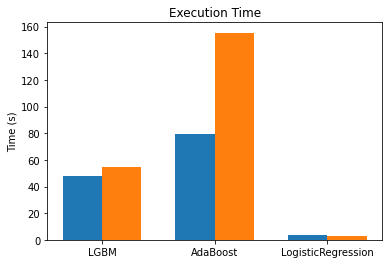

In [52]:
# Plot Execution time
plt.clf()

N = 3
ind = np.arange(N)

fig, ax = plt.subplots()

p1 = ax.bar(ind, timeBase, 0.35)
p2 = ax.bar(ind+0.35, timeBest, 0.35)

ax.set_title('Execution Time')
ax.set_xticks(ind + 0.35 / 2)
ax.set_xticklabels(('LGBM', 'AdaBoost', 'LogisticRegression'))
plt.ylabel("Time (s)")
ax.autoscale_view()
plt.savefig("execTime.png")

plt.show()

<Figure size 432x288 with 0 Axes>

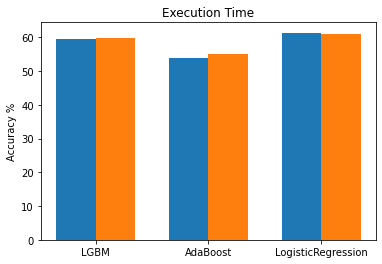

In [58]:
plt.clf()

N = 3
ind = np.arange(N)

fig, ax = plt.subplots()

p1 = ax.bar(ind, tuple([100*x for x in accBase]), 0.35)
p2 = ax.bar(ind+0.35, tuple([100*x for x in accBest]), 0.35)

ax.set_title('Accuracy %')
ax.set_xticks(ind + 0.35 / 2)
ax.set_xticklabels(('LGBM', 'AdaBoost', 'LogisticRegression'))
plt.ylabel("Accuracy %")
ax.autoscale_view()
plt.savefig("accComp.png")

plt.show()
